In [ ]:
!pip install nbimporter

In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import torch.nn.init as init
from torch.autograd import Variable
from dataLoader import loadData

In [2]:
# # Downloading Movielens-1m
# !curl -O http://files.grouplens.org/datasets/movielens/ml-1m.zip
# #     http://www.grouplens.org/system/files/ml-1m.zip
# !unzip ml-1m.zip
# !cd ml-1m/

In [3]:
# import zipfile
# with zipfile.ZipFile('ml-1m.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [4]:
seed = 47
np.random.seed(seed)

In [5]:
# load data
tr, vr = loadData('./ml-1m/ratings.dat', delimiter='::', seed=seed, transpose=False, valfrac=0.1)

reading data...
data read in 4.924822568893433 seconds
loaded dense data matrix


In [6]:
np.save('./tr_movielens_1m', tr)
np.save('./vr_movielens_1m', vr)

In [7]:
tr

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
vr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [9]:
def get_sparsity(mat):
    sparsity = float(len(mat.nonzero()[0]))
    sparsity /= (mat.shape[0] * mat.shape[1])
    sparsity *= 100
    return sparsity

In [10]:
get_sparsity(tr)

4.021525859265269

In [11]:
get_sparsity(vr)

0.44683670296601535

In [12]:
train = tr.copy()

In [13]:
if torch.cuda.is_available() == True:
    device = "cuda"
else:
    device = "cpu"

# Training Denoising Autoencoder

In [ ]:
############## Pytorch model doesn't converge - to do - check #################

from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import regularizers

def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1', kernel_regularizer=regularizers.l2(0.000001))(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(512, activation='selu', name='LatentSpace', kernel_regularizer=regularizers.l2(0.000001))(enc)
    lat_space = Dropout(0.5, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1', kernel_regularizer=regularizers.l2(0.000001))(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred', kernel_regularizer=regularizers.l2(0.000001))(dec)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

In [ ]:
zero_mask = (train == 0)
positive_feedback_mask = (train > 3)
negative_feedback_mask = ((train < 4) * (1 - zero_mask))

In [ ]:
assert (positive_feedback_mask + negative_feedback_mask != zero_mask).all()
assert (positive_feedback_mask + negative_feedback_mask == 1 - zero_mask).all()

In [ ]:
get_sparsity(zero_mask), get_sparsity(positive_feedback_mask), get_sparsity(negative_feedback_mask)

In [ ]:
100 - get_sparsity(zero_mask), get_sparsity(positive_feedback_mask) + get_sparsity(negative_feedback_mask)

In [ ]:
P = 0.4
mask_arr = (np.random.rand(negative_feedback_mask.shape[0], negative_feedback_mask.shape[1]) > P)
y = negative_feedback_mask
X = negative_feedback_mask*mask_arr

In [ ]:
get_sparsity(X), get_sparsity(y)

In [ ]:
model = autoEncoder(X)
model.compile(optimizer = Adam(lr=0.0001), loss='mse')
model.summary()

In [14]:
predicted_tr = np.load('predicted_tr.npy')
augmented_train = np.load('augmented_train.npy')

In [ ]:
# hist = model.fit(x=X, y=y,
#                   epochs=300,
#                   batch_size=128,
#                   shuffle=True,
#                   validation_split=0.0)

In [ ]:
import matplotlib.pyplot as plt 

def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    #plt.plot(hist.history['val_loss'])

plot_hist(hist)

In [ ]:
np.set_printoptions(precision=3)
predicted_tr = model.predict(X)

In [ ]:
(predicted_tr > 0.4).sum(), (y == 1).sum() # predicted vs real

In [ ]:
(X>0.5).sum() # trained on

In [ ]:
(y * (predicted_tr>0.4)).sum()/(predicted_tr>0.4).sum() # accuracy on actual 

In [ ]:
(y * (predicted_tr>0.5)).sum()/((predicted_tr>0.5).sum())

In [ ]:
((predicted_tr>0.5)  * (X<0.5)).sum() # predicted values which were not in the train matrix

In [ ]:
((y * (((predicted_tr>0.5)  * (X<0.5)))) == 1).sum()/(((predicted_tr>0.5)  * (X<0.5))).sum()

In [ ]:
augmented_train = model.predict(y)

In [ ]:
(augmented_train>0.5).sum()

In [ ]:
(y* (augmented_train>0.8)).sum()/(((augmented_train>0.8)).sum())

In [ ]:
threshold = 0.3

In [ ]:
((augmented_train > threshold) * (tr==0)).sum() # new values

In [ ]:
p_probs = [(tr == 1).sum()/((tr > 0) & (tr < 4)).sum(), (tr == 2).sum()/(((tr > 0) & (tr < 4))).sum(), (tr == 3).sum()/((tr > 0) & (tr < 4)).sum()]
p_probs

In [ ]:
augmented_train = tr + (predicted_tr > threshold) * (tr == 0) * np.random.choice(np.arange(1, 4), tr.shape, p=p_probs)

In [ ]:
get_sparsity(tr), get_sparsity(augmented_train)

In [ ]:
(np.isin(tr, augmented_train)).all()

In [ ]:
((tr == 0) * (augmented_train > 0)).sum()

In [ ]:
np.save('predicted_tr', predicted_tr)
np.save('augmented_train', augmented_train)

In [15]:
features_length = train.shape[1]
class NetD(torch.nn.Module):
    def __init__(self, use_cuda=True):
        super(NetD, self).__init__()
        self.use_cuda = use_cuda
        # top
        self.t1 = torch.nn.Linear(features_length, 1024)
        # bottom
        self.b1 = torch.nn.Linear(features_length, 1024)
        # combined
        self.fc = torch.nn.Linear(2 * 1024, features_length)
    def forward(self, xr, xf):
        # get filt
#         filt = (torch.abs((real > 0.3).float() * fake - real))/real.shape[0]
#         filt = torch.abs((xr != 0).float().cuda() * xf.cuda() - xr.cuda())/xr.shape[0]
#         filt = torch.abs(xf - xr)
#         filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
#         filt = torch.abs((real != 0).float().cuda() * fake.cuda() - real.cuda())

#         filt = torch.abs((xr != 0).int() * xf - xr)
#         filt = 1 - (xr * (xf >= 0.5).float()) - ((1-xr) * (xf < 0.5).float())
        # random swap
        idr = torch.multinomial(torch.Tensor([0.5,0.5]), xr.size(0), replacement=True)
        idrx = idr.float().unsqueeze(1).expand_as(xr)
        if self.use_cuda: 
            idrx = idrx.cuda()
        idrx = Variable(idrx)
        xt = xr * idrx + xf * (1 - idrx)
        xb = xr * (1 - idrx) + xf * idrx
        # top : real
        xt = F.relu(self.t1(xt))
        # bottom : fake
        xb = F.relu(self.b1(xb))
        # combined
        x = torch.cat((xt, xb), 1)
        x = torch.tanh(self.fc(x))
        # apply filter, aggregate
#         print(filt.type(), x.type())
#         x = filt * x

        x = x.mean(dim = 1).squeeze()
        # use sign, because of swapping
        sgn = idr * 2 - 1
        if self.use_cuda: 
            sgn = sgn.cuda()
        sgn = Variable(sgn.float())
        x = sgn * x
#         print(x.shape, xr.shape, xf.shape, d_my(xr, xf))
#         print(x)
#         print(xr)
#         print(xf)
#         print (x)
#         print(d_my(xr, xf))
#         print(x * (x <= d_my(xr, xf)).float() + d_my(xr, xf) * (x > d_my(xr, xf)).float())
#         if x > d_my(xr, xf):
#             x = d_my(xr, xf)
        x = x * (x <= d_my(xr, xf)).float() + d_my(xr, xf) * (x > d_my(xr, xf)).float()
        return x
        
# netG = torch.nn.Sequential(
#     torch.nn.Linear(nz, 1024),
#     torch.nn.ReLU(),
#     torch.nn.Linear(1024, features_length),
#     torch.nn.Sigmoid()*5
#     )

class NetG(nn.Module):
    
    def __init__(self):

        super(NetG, self).__init__()

        self.netGen = torch.nn.Sequential( 
                                torch.nn.Linear(nz, 1024), 
#                                 torch.nn.BatchNorm1d(1024),
                                torch.nn.Sigmoid(), 
                                nn.Dropout(0.5),
                                torch.nn.Linear(1024, 1024),
#                                 torch.nn.BatchNorm1d(1024),
                                torch.nn.ReLU(), 
                                nn.Dropout(0.6),
                                torch.nn.Linear(1024, features_length), 
#                                 torch.nn.BatchNorm1d(features_length),
#                                 nn.Dropout(0.7),
#                                 torch.nn.Sigmoid()
                                )

#         self.net = nn.Sequential(
#                                  nn.Linear(nz,1024),
# #                                  nn.Dropout(0.3)
#                                  nn.ReLU(),
#                                  nn.Linear(1024,2048),
#                                  nn.Sigmoid(),
#                                  nn.Dropout(0.3),
#                                  nn.Linear(2048,features_length),
# #                                  nn.Sigmoid()
#                                  nn.Dropout(0.5)
#                                     )
        
    def forward(self, x):
        x = self.netGen(x)
        return F.dropout(x, 0.7)
#         return 5 * self.netGen(x)
#         return torch.sigmoid(x) 
#         return x*5 # to get values in range [0,5]

In [16]:
def get_random_batch(mat, batch_size=64):
    '''
    returns random rows of size batch_size
    '''
    rand_rows = np.random.randint(mat.shape[0], size=batch_size)
#     print(mat.shape, rand_rows)
#     print(mat[rand_rows].shape)
    return mat[rand_rows]

In [17]:
train = torch.autograd.Variable(torch.Tensor(train))
augmented_train = torch.autograd.Variable(torch.Tensor(augmented_train))

In [18]:
get_sparsity(train.cpu().numpy()), get_sparsity(augmented_train.cpu().numpy())

(4.021525859265269, 4.134020185630605)

In [ ]:
# xx = get_random_batch(train)
# xy = get_random_batch(train)

In [ ]:
# d_my(xx, xy)

In [ ]:
# torch.sum(torch.abs(torch.abs(xx != 0).float()*xy - xy), 1)

In [ ]:
# xx > xy

In [19]:
def d_my(x_r, x_g): # custom loss -todo
    return torch.sum(torch.abs((x_r != 0).float() * x_g - x_r), 1)/x_r.shape[1]

In [20]:
def train_GAN(netD, netG, train_mat, steps_per_epoch = 300, epochs = 300):
    gen_iterations = 0
    eval_losses = []
    d_iter = 5
    g_iter = 1
    for epoch in range(epochs):
        i = 0
        while i < steps_per_epoch:
            ############################
            # (1) Update D network
            ###########################
            for p in netD.parameters(): # reset requires_grad
                p.requires_grad = True # they are set to False below in netG update
            d_iter = d_iter
            j = 0
            while j < d_iter*5:
                j += 1
                # load real data
                i += 1
    #             X, _ = data_iter.next()
                X = get_random_batch(train, batch_size=batch_size).to(device)
    #             X += torch.Tensor(np.random.normal(0, 0.2, X.shape))
    #             print(X >= 0.5)
    # #             X = X.view(X.size(0), -1)
    #             X = (X >= 0.5).float()
#                 if cuda: 
#                     X = X.cuda()
#                 real = Variable(X)
#                 real = X.clone()
#                 real = X + fake * (X == 0).float()
                # generate fake data
                noise = torch.randn(batch_size, nz).to(device)
#                 if cuda: 
#                     noise = noise.cuda()
                with torch.no_grad():
                    noisev = Variable(noise) # totally freeze netG
                    
#                 fake = netG(noisev).to(device)
                fake = Variable(netG(noisev).data).to(device)
#                 fake.requires_grad = False
    #             print(real[0,:20], fake[0,:20])
#                 real + fake * (real == 0).float()
#                 fake = fake * Variable(real != 0).float().cuda()

    #             real + fake * (real == 0).float()
    #             print(real[0,:20], fake[0,:20])
#                 fake.requires_grad = False
    #             print(real.shape, fake.shape)

                # compute gradient, take step
                netD.zero_grad()
    #             print('real', real[:10, :20])
    #             print('fake', fake[:10, :20])
    #             print(real.type(), fake.type())
    #             print(fake)
#                 print(real)
#                 real = X + fake * (X == 0).float()
#                 print(real[0])
#                 print(fake[0])
                real = Variable(X)
                out = netD(real, fake)

                outputD = torch.mean(out) + lamba * out.norm()
                stdD = torch.std(out)
                outputD.backward(mone)
                optimizerD.step()
    #             print(out.shape)
            ############################
            # (2) Update G network
            ###########################
            g_iter = g_iter
            j = 0
            while j < g_iter:
                j += 1
                for p in netD.parameters():
                    p.requires_grad = False # to avoid computation
#                 for p in netG.parameters():
#                     p.requires_grad = True # to avoid computation
                    
                netG.zero_grad()

                # load real data
                i += 1
                X = get_random_batch(train, batch_size=batch_size).to(device)
    #             X += torch.Tensor(np.random.normal(0, 0.2, X.shape))
    #             X = X.view(X.size(0), -1)
    #             X = (X >= 0.5).float()
#                 if cuda: 
#                     X = X.cuda()
#                 real = Variable(X)
#                 real = X.clone()

                # update generator
                noise = torch.randn(batch_size, nz).to(device)
#                 if cuda: 
#                     noise = noise.cuda()
                fake = netG(noisev).to(device)
#                 noisev = Variable(noise)

#                 fake = Variable(netG(noisev).data)

#                 real = real + fake * (real == 0).float()
#                 fake = fake * Variable(real != 0).float().cuda()
                
    #             fake = fake * Variable(real != 0).float().cuda()
#                 fake.requires_grad = False
    #             fake = Variable(netG(noisev)).data
    #             fake = fake * Variable(((real != 0) & (fake > 0.8))).float().cuda()
    
#                 fake.requires_grad = True
#                 real = X + fake * (X == 0).float()
                real = Variable(X)
                out = netD(real, fake)
                outputG = torch.mean(out) + lamba * out.norm()
                stdG = torch.std(out)
#                 print(real.requires_grad, fake.requires_grad)
                outputG.backward(one)
                optimizerG.step()

                gen_iterations += 1

    #             print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f '% (epoch, epochs, i, len(data_loader), gen_iterations, outputD.item(), outputG.item()))
    #             print('output_D', outputD.item(), gen_iterations)
    #             print('output_G', outputG.item(), gen_iterations)
    #             print('std_D', stdD.item(), gen_iterations)
    #             print('std_G', stdG.item(), gen_iterations)

                # evaluation
                if gen_iterations % 100 == 0: # todo- to change
    #                 gen.eval()
    #                 z_vector_eval = make_some_noise(128)
    #                 fake_rows_eval = gen(z_vector_eval)
    #                 real_rows_eval = get_random_batch(train, 128)
            #         print(fake_rows[0][:10]) enable to see some results
    #                 fake = Variable(netG(noisev).data).round()
    #                 fake = ((real != 0) & (fake != 0))
    #                 print(fake)
                    eval_loss = F.mse_loss(fake, real, reduction='mean')
                    eval_losses.append(eval_loss)
                    print("######"*40)
                    print('Epoch number {}. my distance between random real and fake samples sum {}'.format(epoch, d_my(real, fake).sum()))
                    print('Epoch number {}. my distance between random real and fake samples {}'.format(epoch, d_my(real, fake).mean()))
                    print('Epoch number {}. MSE distance between random real and fake samples {}'.format(epoch, eval_loss))
                    print("######"*40)
                    
    return eval_losses

In [23]:
lrD = 5e-4
lrG = 5e-4
batch_size = 128
cuda = True
epochs = 500 #change
seed = 1
nz = 16
d_iter = 5
g_iter = 1
lamba = 2e-4

In [24]:
# networks
netD_tr = NetD().to(device)
netG_tr = NetG().to(device)
print(netD_tr)
print(netG_tr)
optimizerG = optim.RMSprop(netG_tr.parameters(), lr=lrG)
optimizerD = optim.RMSprop(netD_tr.parameters(), lr=lrD)
one = torch.FloatTensor([1]).to(device)
mone = (-1 * one).to(device)

NetD(
  (t1): Linear(in_features=3706, out_features=1024, bias=True)
  (b1): Linear(in_features=3706, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=3706, bias=True)
)
NetG(
  (netGen): Sequential(
    (0): Linear(in_features=16, out_features=1024, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.6)
    (6): Linear(in_features=1024, out_features=3706, bias=True)
  )
)


In [25]:
eval_losses_tr = train_GAN(netD_tr, netG_tr, train)

KeyboardInterrupt: 

In [ ]:
# torch.save(netG.state_dict(), './netG-1m')
# torch.save(netD.state_dict(), './netD-1m')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(eval_losses_tr)
plt.show()

In [26]:
netG_tr.eval()

NetG(
  (netGen): Sequential(
    (0): Linear(in_features=16, out_features=1024, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.6)
    (6): Linear(in_features=1024, out_features=3706, bias=True)
  )
)

In [27]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)
fake = netG_tr(noisev)

In [28]:
fake.shape

torch.Size([6040, 3706])

In [29]:
fake = np.around(fake.detach().cpu().numpy())

In [30]:
np.unique(fake)

array([-3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
      dtype=float32)

In [31]:
fake = fake * (fake <= 5).astype(int)

In [32]:
np.unique(fake)

array([-3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.])

In [33]:
get_sparsity(fake)

26.924827467897057

In [34]:
print(5, (5 == fake.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

5 566145 226310
4 1576161 348971
3 1537743 261197
2 1191324 107557
1 812316 56174
0 16357322 21384031


As we see there is a significant bias towards higher ratings

In [39]:
# networks
netD_augm = NetD().to(device)
netG_augm = NetG().to(device)
print(netD_augm)
print(netG_augm)
optimizerG = optim.RMSprop(netG_augm.parameters(), lr=lrG)
optimizerD = optim.RMSprop(netD_augm.parameters(), lr=lrD)
one = torch.FloatTensor([1]).to(device)
mone = (-1 * one).to(device)

NetD(
  (t1): Linear(in_features=3706, out_features=1024, bias=True)
  (b1): Linear(in_features=3706, out_features=1024, bias=True)
  (fc): Linear(in_features=2048, out_features=3706, bias=True)
)
NetG(
  (netGen): Sequential(
    (0): Linear(in_features=16, out_features=1024, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.6)
    (6): Linear(in_features=1024, out_features=3706, bias=True)
  )
)


In [36]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)
fake = netG_augm(noisev)

In [37]:
fake = np.around(fake.detach().cpu().numpy())
np.unique(fake)

array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.], dtype=float32)

In [38]:
# without train
print(5, (5 == fake.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

5 0 226310
4 338 348971
3 17629 261197
2 295849 107557
1 1623798 56174
0 18513349 21384031


In [40]:
eval_losses_aug = train_GAN(netD_augm, netG_augm, augmented_train)

################################################################################################################################################################################################################################################
Epoch number 8. my distance between random real and fake samples sum 14.237488746643066
Epoch number 8. my distance between random real and fake samples 0.11123038083314896
Epoch number 8. MSE distance between random real and fake samples 3.736663818359375
################################################################################################################################################################################################################################################
################################################################################################################################################################################################################################################
Epoch number 16. my 

################################################################################################################################################################################################################################################
Epoch number 99. my distance between random real and fake samples sum 15.171722412109375
Epoch number 99. my distance between random real and fake samples 0.11852908134460449
Epoch number 99. MSE distance between random real and fake samples 2.4651362895965576
################################################################################################################################################################################################################################################
################################################################################################################################################################################################################################################
Epoch number 108

################################################################################################################################################################################################################################################
Epoch number 191. my distance between random real and fake samples sum 15.955431938171387
Epoch number 191. my distance between random real and fake samples 0.12465181201696396
Epoch number 191. MSE distance between random real and fake samples 4.444432258605957
################################################################################################################################################################################################################################################
################################################################################################################################################################################################################################################
Epoch number 1

################################################################################################################################################################################################################################################
################################################################################################################################################################################################################################################
Epoch number 283. my distance between random real and fake samples sum 13.72924518585205
Epoch number 283. my distance between random real and fake samples 0.10725972801446915
Epoch number 283. MSE distance between random real and fake samples 3.363431930541992
################################################################################################################################################################################################################################################
###############

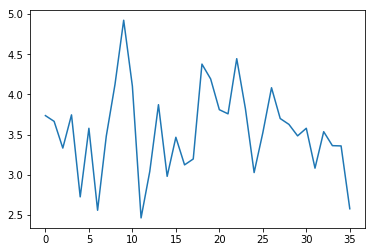

In [42]:
import matplotlib.pyplot as plt

plt.plot(eval_losses_aug)
plt.show()

In [43]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)
fake = netG_augm(noisev)

In [44]:
fake = np.around(fake.detach().cpu().numpy())

In [45]:
np.unique(fake)

array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,
        9., 10., 11., 12., 13.], dtype=float32)

In [46]:
fake = fake * (fake <= 5).astype(int)

In [47]:
print(5, (5 == fake.round()).sum(), (5 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(4, (4 == fake.round()).sum(), (4 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(3, (3 == fake.round()).sum(), (3 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(2, (2 == fake.round()).sum(), (2 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(1, (1 == fake.round()).sum(), (1 == (tr + vr)[:fake.shape[0], :].round()).sum())
print(0, (0 == fake.round()).sum(), (0 == (tr + vr)[:fake.shape[0], :].round()).sum())

5 871909 226310
4 2270321 348971
3 2134716 261197
2 942572 107557
1 251716 56174
0 15891479 21384031


In [48]:
netG_tr.eval()
netG_augm.eval()

NetG(
  (netGen): Sequential(
    (0): Linear(in_features=16, out_features=1024, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.6)
    (6): Linear(in_features=1024, out_features=3706, bias=True)
  )
)

In [49]:
noise = torch.randn(train.shape[0], nz).to(device)
noisev = Variable(noise)

fake_tr = netG_tr(noisev)
fake_aug = netG_augm(noisev)

In [50]:
torch.unique(fake_tr.round()), torch.unique(fake_aug.round())

(tensor([-3., -2., -1., -0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        device='cuda:0', grad_fn=<NotImplemented>),
 tensor([-1., -0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.], device='cuda:0',
        grad_fn=<NotImplemented>))

In [51]:
fake_tr = fake_tr.clamp(0,5).detach().cpu().numpy().round()
fake_aug = fake_aug.clamp(0,5).detach().cpu().numpy().round()

In [52]:
print(5, (5 == fake_tr).sum(), (5 == (tr + vr)[:fake.shape[0], :]).sum())
print(4, (4 == fake_tr).sum(), (4 == (tr + vr)[:fake.shape[0], :]).sum())
print(3, (3 == fake_tr).sum(), (3 == (tr + vr)[:fake.shape[0], :]).sum())
print(2, (2 == fake_tr).sum(), (2 == (tr + vr)[:fake.shape[0], :]).sum())
print(1, (1 == fake_tr).sum(), (1 == (tr + vr)[:fake.shape[0], :]).sum())
print(0, (0 == fake_tr).sum(), (0 == (tr + vr)[:fake.shape[0], :]).sum())

5 634896 226310
4 1577801 348971
3 1537091 261197
2 1192444 107557
1 812699 56174
0 16629309 21384031


In [53]:
print(5, (5 == fake_aug).sum(), (5 == (tr + vr)[:fake.shape[0], :]).sum())
print(4, (4 == fake_aug).sum(), (4 == (tr + vr)[:fake.shape[0], :]).sum())
print(3, (3 == fake_aug).sum(), (3 == (tr + vr)[:fake.shape[0], :]).sum())
print(2, (2 == fake_aug).sum(), (2 == (tr + vr)[:fake.shape[0], :]).sum())
print(1, (1 == fake_aug).sum(), (1 == (tr + vr)[:fake.shape[0], :]).sum())
print(0, (0 == fake_aug).sum(), (0 == (tr + vr)[:fake.shape[0], :]).sum())

5 506360 226310
4 2963175 348971
3 2273712 261197
2 769288 107557
1 156109 56174
0 15715596 21384031


In [54]:
get_sparsity(tr), get_sparsity(fake_tr), get_sparsity(fake_aug)

(4.021525859265269, 25.70974489194183, 29.791692726668405)

In [ ]:
# tr_orig, vr_1 = loadData('./ml-1m/ratings.dat', delimiter='::', seed=seed,  transpose=False, valfrac=0.1)

In [55]:
import nbimporter 
import matrix_factorization

Importing Jupyter notebook from matrix_factorization.ipynb


In [56]:
rand_ix = np.random.randint(0, fake_tr.shape[0], 300)

In [57]:
adding_fake_autoenc = fake_tr[rand_ix,:]
adding_fake_autoenc_lus_gan = fake_aug[rand_ix,:]

In [59]:
np.unique(adding_fake_autoenc_lus_gan[0,:])

array([0., 1., 2., 3., 4., 5.], dtype=float32)

In [64]:
(adding_fake_autoenc == 1).sum()

40476

In [65]:
(adding_fake_autoenc_lus_gan == 1).sum()

7862

In [67]:
np.unique(adding_fake_autoenc_lus_gan[0,:])

array([0., 1., 2., 3., 4., 5.], dtype=float32)

In [68]:
adding_fake[0,0:200]

NameError: name 'adding_fake' is not defined

In [69]:
adding_fake_autoenc_lus_gan[0,0:200]

array([0., 0., 0., 3., 0., 4., 0., 3., 0., 0., 0., 2., 0., 4., 0., 4., 0.,
       0., 0., 3., 0., 0., 3., 0., 0., 3., 0., 5., 0., 3., 0., 0., 4., 0.,
       0., 4., 0., 0., 0., 0., 0., 0., 3., 3., 4., 0., 0., 0., 4., 0., 4.,
       5., 0., 0., 1., 0., 4., 2., 3., 3., 4., 3., 0., 3., 0., 0., 3., 0.,
       3., 2., 3., 0., 0., 2., 0., 4., 0., 2., 0., 0., 0., 4., 0., 4., 0.,
       0., 0., 0., 0., 3., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.,
       3., 0., 3., 0., 0., 4., 0., 3., 0., 0., 0., 0., 0., 3., 5., 3., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 3., 0., 0., 4., 0., 0., 3., 0., 0., 4., 3., 0., 0.,
       0., 0., 0., 0., 4., 0., 0., 3., 0., 3., 0., 0., 0., 0., 2., 0., 0.,
       4., 0., 4., 2., 0., 0., 0., 4., 3., 0., 3., 4., 4., 3., 0., 0., 0.,
       0., 4., 0., 3., 3., 0., 0., 0., 0., 0., 3., 3., 0.], dtype=float32)

In [70]:
tr_auto_enc = np.append(tr, adding_fake_autoenc, axis=0)
tr_auto_enc_plus_gan = np.append(tr, adding_fake_autoenc_lus_gan, axis=0)

In [71]:
iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([60], vr, learning_rate=0.001)

Iteration: 60
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
Train mse: 0.7187739765016317
Test mse: 0.7761838306708981


In [ ]:
get_sparsity(augmented_train.cpu().numpy())

In [72]:
# iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(augmented_train.cpu().numpy(), 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([60], vr, learning_rate=0.001)

Iteration: 60
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
Train mse: 0.717847971729219
Test mse: 0.772331136931587


In [ ]:
# iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(tr, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([50], vr, learning_rate=0.001)

In [ ]:
# iter_array = [1, 2, 5, 10, 25]
MF_SGD = matrix_factorization.ExplicitMF(augmented_train.cpu().numpy(), 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([50], vr, learning_rate=0.001)

In [ ]:
tr.shape, augmented_train.cpu().numpy().shape, tr_auto_enc.shape, tr_auto_enc_plus_gan.shape

In [ ]:
get_sparsity(tr_auto_enc), get_sparsity(tr_auto_enc_plus_gan)

In [ ]:
# iter_array = [1, 2, 5, 10, 25, 40]

MF_SGD = matrix_factorization.ExplicitMF(tr_auto_enc, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve(iter_array, vr, learning_rate=0.001)

In [73]:
# iter_array = [1, 2, 5, 10, 25, 40]

MF_SGD = matrix_factorization.ExplicitMF(tr_auto_enc_plus_gan, 40, learning='sgd', verbose=True)
# iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

# iter_array = [10]
# iter_array = [1, 2, 5, 10, 25]
MF_SGD.calculate_learning_curve([60], vr, learning_rate=0.001)

Iteration: 60
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
Train mse: 0.5350130473722049
Test mse: 0.7831244021517524
